# REGRESSION: Bitcoin Price Forecast

***


## INTRODUCTION

This project used data from <b style="color:#4361ee">Kraken API</b> and initially applid one machine learning model, <b style="color:#4361ee">Support Vector Machine</b>, to forcast the future price of <b style="color:#4361ee">Bitcoin.</b>

In [472]:
import numpy as np
import pandas as pd
import json
import datetime
import time
import requests

In [473]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams["font.size"]=14
matplotlib.rcParams["figure.figsize"]= (18,8)
matplotlib.rcParams["figure.facecolor"]="#00000000"

import seaborn as sns
sns.set_style("darkgrid")
import plotly.express as px

## DATA COLLECTION

Kraken gives historical cryptocurrency data. However, the current historical data available is March 31, 2022.
Therefore, additional data need to be pulled from the API market data endpoint.

### 1. Kraken Historical OHLCVT 

* https://support.kraken.com/hc/en-us/articles/360047124832-Downloadable-historical-OHLCVT-Open-High-Low-Close-Volume-Trades-data

* The data given is in one minute timeframe, so we will use the 1440 (daily timeframe)
* The date is in Unix timestamp, so need to be converted to regular date time 

In [474]:
# The columns from the csv file
xbt_cols = ["date","open", "high", "low", "close", "volume", "trades"]

In [475]:
xbt_raw = pd.read_csv("data/XBTUSD_1440.csv", names=xbt_cols)

In [476]:
# Convert Unix timestamp
xbt_raw["date"] = pd.to_datetime(xbt_raw["date"],unit='s')

In [477]:
xbt_raw.to_csv("data/xbt_raw.csv")

### 2. Kraken API Market data OHLC endpoint
* Using OHLC endpoint for 2022 data
* https://docs.kraken.com/rest/#operation/getTickerInformation
* Unix timestamp converter https://www.epochconverter.com/

In [478]:
# The columns from OHLC API (different from historical data)

kraken_ohlc_cols = ["date","open", "high", "low", "close", "vwap","volume", "trades"]

* Without specifying "since" parameter, the response will give the current day data and only 720 data available

In [479]:
resp = requests.get('https://api.kraken.com/0/public/OHLC?pair=XBTUSD&interval=1440&since=unix_now').json()

In [480]:
xbt_apr22_df = pd.DataFrame(resp["result"]['XXBTZUSD'])

In [481]:
xbt_apr22_df.columns = kraken_ohlc_cols

In [482]:
xbt_apr22_df["date"] = pd.to_datetime(xbt_apr22_df["date"],unit='s')
xbt_apr22_df.head(3)

,date,open,high,low,close,vwap,volume,trades
0,2020-06-18,9453.1,9480.0,9268.2,9381.5,9387.1,3652.89691828,15791
1,2020-06-19,9381.5,9439.7,9219.9,9302.1,9323.4,4506.12586124,17317
2,2020-06-20,9301.2,9394.9,9165.0,9355.6,9294.5,2127.73045817,9012


In [483]:
xbt_apr22_df.tail(3)

,date,open,high,low,close,vwap,volume,trades
717,2022-06-05,29850.8,30162.4,29514.0,29907.6,29846.8,963.56113985,11190
718,2022-06-06,29907.6,31725.6,29881.9,31356.3,31263.4,3447.46292616,21505
719,2022-06-07,31353.1,31442.6,29200.2,29300.0,30112.4,1668.66244919,7675


### Appending data from OHLC API to dataframe from historical data

<b>Drop vwap column since there's no vwap column in the historical data</b>

In [484]:
# Drop vwap column since there's no vwap column in the historical data

xbt_apr22_df.drop("vwap", axis=1, inplace=True)
xbt_apr22_df.head(3)

,date,open,high,low,close,volume,trades
0,2020-06-18,9453.1,9480.0,9268.2,9381.5,3652.89691828,15791
1,2020-06-19,9381.5,9439.7,9219.9,9302.1,4506.12586124,17317
2,2020-06-20,9301.2,9394.9,9165.0,9355.6,2127.73045817,9012


<b> Select the data after March 31,2022 </b>

In [485]:
xbt_apr22 = xbt_apr22_df[xbt_apr22_df["date"] > "2022-03-31"]

<b> Combine the two dataframes</b>

In [486]:
btc_df_raw = pd.concat([xbt_raw, xbt_apr22],ignore_index=True)

In [487]:
btc_df_raw.head(3)

,date,open,high,low,close,volume,trades
0,2013-10-06,122.0,122.0,122.0,122.0,0.1,1
1,2013-10-07,123.61,123.61,123.61,123.61,0.1,1
2,2013-10-08,123.91,124.19,123.9,124.18,3.9916,4


In [488]:
btc_df_raw.tail(3)

,date,open,high,low,close,volume,trades
3152,2022-06-05,29850.8,30162.4,29514.0,29907.6,963.56113985,11190
3153,2022-06-06,29907.6,31725.6,29881.9,31356.3,3447.46292616,21505
3154,2022-06-07,31353.1,31442.6,29200.2,29300.0,1668.66244919,7675


In [489]:
btc_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3155 entries, 0 to 3154
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3155 non-null   datetime64[ns]
 1   open    3155 non-null   object        
 2   high    3155 non-null   object        
 3   low     3155 non-null   object        
 4   close   3155 non-null   object        
 5   volume  3155 non-null   object        
 6   trades  3155 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 172.7+ KB


In [490]:
btc_df_raw = btc_df_raw.astype({"open":"float64", 
                               "high":"float64", 
                                "low":"float64", 
                               "close":"float64", 
                             "volume":"float64"})

In [491]:
btc_df_raw.to_csv("data/btc_df_raw.csv") # save data for later use


## DATA PREPROCESSING


### Create more features 

In [492]:
btc_df = pd.read_csv("data/btc_df_raw.csv", index_col=0)

In [493]:
btc_df.head(2)

,date,open,high,low,close,volume,trades
0,2013-10-06,122.00,122.00,122.00,122.00,0.1,1
1,2013-10-07,123.61,123.61,123.61,123.61,0.1,1


In [494]:
btc_df.tail(2)

,date,open,high,low,close,volume,trades
3153,2022-06-06,29907.6,31725.6,29881.9,31356.3,3447.462926,21505
3154,2022-06-07,31353.1,31442.6,29200.2,29300.0,1668.662449,7675


In [495]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3155 entries, 0 to 3154
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3155 non-null   object 
 1   open    3155 non-null   float64
 2   high    3155 non-null   float64
 3   low     3155 non-null   float64
 4   close   3155 non-null   float64
 5   volume  3155 non-null   float64
 6   trades  3155 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 197.2+ KB


#### Split date column to year, month, day

In [496]:
def date_split(df):
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    return(df)

In [497]:
btc_df = date_split(btc_df)

In [498]:
btc_df = btc_df[["date","year", "month", "day", "open", "high", "low", "close", "volume", "trades"]]

In [499]:
btc_df.head(3)

,date,year,month,day,open,high,low,close,volume,trades
0,2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1
1,2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1
2,2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4


In [500]:
btc_df = btc_df.set_index("date")

In [501]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades
date,,,,,,,,,
2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1
2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1
2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4


#### Adding Yesterday prices, volume, trades

In [502]:
def yesterday_data(df):
    df["open_yesterday"] = df["open"].shift(1)
    df["high_yesterday"] = df["high"].shift(1)
    df["low_yesterday"] = df["low"].shift(1)
    df["close_yesterday"] = df["close"].shift(1)
    df["volume_yesterday"] = df["volume"].shift(1)
    df["trades_yesterday"] = df["trades"].shift(1)
    return(df)

In [503]:
btc_df = yesterday_data(btc_df)

#### Adding % change of yesterday and the day before yesterday

price_1D_change = (today_price - yesterday_price)/yesterday_price

In [504]:
def change_1D(df):
    df["open_1D_change"] = btc_df["open"].pct_change().shift(1)
    df["high_1D_change"] = btc_df["high"].pct_change().shift(1)
    df["low_1D_change"]  = df["low"].pct_change().shift(1)
    df["close_1D_change"] = df["close"].pct_change().shift(1)
    df["volume_1D_change"] = df["volume"].pct_change().shift(1)
    df["trades_1D_change"] = df["trades"].pct_change().shift(1)
    return(df)
    

In [505]:
btc_df = change_1D(btc_df)

#### Average 7 days

- rolling will include the current row to calculate
- so if we are at row#8 (index=7), we can calculate mean of the first 7 rows 
- then shiff the value to row#8

In [506]:
def moving_ave_7(df):
    df["open_average_7D"] = df["open"].rolling(7).mean().shift(1)
    df["high_average_7D"] = df["high"].rolling(7).mean().shift(1)
    df["low_average_7D"] = df["low"].rolling(7).mean().shift(1)
    df["close_average_7D"] = df["close"].rolling(7).mean().shift(1)
    df["volume_average_7D"] = df["volume"].rolling(7).mean().shift(1)
    df["trades_average_7D"] = df["trades"].rolling(7).mean().shift(1)
    
    return(df)

In [507]:
btc_df = moving_ave_7(btc_df)

#### % change 7 days

In [508]:
def change_pct_7D(df):
    df["open_%change_7D"] = df["open_1D_change"].rolling(7).mean().shift(1)
    df["high_%change_7D"] = df["high_1D_change"].rolling(7).mean().shift(1)
    df["low_%change_7D"] = df["low_1D_change"].rolling(7).mean().shift(1)
    df["close_%change_7D"] = df["close_1D_change"].rolling(7).mean().shift(1)
    df["volume_%change_7D"] = df["volume_1D_change"].rolling(7).mean().shift(1)
    df["trades_%change_7D"] = df["trades_1D_change"].rolling(7).mean().shift(1)
    
    return(df)

In [509]:
btc_df = change_pct_7D(btc_df)

#### Simple Moving Average 9, 20, 50
- Will only use ["close"] here

In [510]:
def moving_avgs_pop(df):
    df["moving_average_9"] = df["close"].rolling(9).mean().shift(1)
    df["moving_average_20"] = df["close"].rolling(20).mean().shift(1)
    df["moving_average_50"] = df["close"].rolling(50).mean().shift(1)
    
    return(df)

In [511]:
btc_df = moving_avgs_pop(btc_df)

<b> Set the display to see all columns </b>

In [512]:
pd.set_option("display.max_columns", len(btc_df.columns))

In [513]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1,122.00,122.00,122.00,122.00,0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4,123.61,123.61,123.61,123.61,0.1,1.0,0.013197,0.013197,0.013197,0.013197,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [514]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-05,2022,6,5,29850.8,30162.4,29514.0,29907.6,963.561140,11190,29676.4,29954.5,29450.1,29850.0,783.344337,10432.0,-0.024807,-0.022975,0.006669,0.005850,-0.683204,-0.421858,30265.671429,31161.857143,29556.000000,30383.771429,3044.968723,22382.000000,0.006855,0.006682,0.005592,0.006180,0.331916,0.016631,30031.822222,29785.690,33968.052
2022-06-06,2022,6,6,29907.6,31725.6,29881.9,31356.3,3447.462926,21505,29850.8,30162.4,29514.0,29907.6,963.561140,11190.0,0.005877,0.006941,0.002170,0.001930,0.230061,0.072661,30384.342857,31248.628571,29655.142857,30449.085714,2997.989385,21800.428571,0.006181,0.004165,0.005280,0.004817,0.339114,0.027110,30179.333333,29789.765,33758.584
2022-06-07,2022,6,7,31353.1,31442.6,29200.2,29300.0,1668.662449,7675,29907.6,31725.6,29881.9,31356.3,3447.462926,21505.0,0.001903,0.051826,0.012465,0.048439,2.577835,0.921805,30449.642857,31182.800000,29740.871429,30398.314286,2682.755914,20398.571429,0.004820,0.003563,0.003986,0.002974,0.357737,0.036215,30438.922222,29837.165,33592.086


#### Drop NaN

In [515]:
len(btc_df)

3155

In [516]:
btc_df = btc_df.dropna()

In [517]:
len(btc_df)

3105

In [518]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [519]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-05,2022,6,5,29850.8,30162.4,29514.0,29907.6,963.561140,11190,29676.4,29954.5,29450.1,29850.0,783.344337,10432.0,-0.024807,-0.022975,0.006669,0.005850,-0.683204,-0.421858,30265.671429,31161.857143,29556.000000,30383.771429,3044.968723,22382.000000,0.006855,0.006682,0.005592,0.006180,0.331916,0.016631,30031.822222,29785.690,33968.052
2022-06-06,2022,6,6,29907.6,31725.6,29881.9,31356.3,3447.462926,21505,29850.8,30162.4,29514.0,29907.6,963.561140,11190.0,0.005877,0.006941,0.002170,0.001930,0.230061,0.072661,30384.342857,31248.628571,29655.142857,30449.085714,2997.989385,21800.428571,0.006181,0.004165,0.005280,0.004817,0.339114,0.027110,30179.333333,29789.765,33758.584
2022-06-07,2022,6,7,31353.1,31442.6,29200.2,29300.0,1668.662449,7675,29907.6,31725.6,29881.9,31356.3,3447.462926,21505.0,0.001903,0.051826,0.012465,0.048439,2.577835,0.921805,30449.642857,31182.800000,29740.871429,30398.314286,2682.755914,20398.571429,0.004820,0.003563,0.003986,0.002974,0.357737,0.036215,30438.922222,29837.165,33592.086


#### Save dataframe for later use for Machine Learaning model

In [520]:
btc_df.to_csv("data/btc_df.csv")

# VISUALIZATION

In [521]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [522]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-05,2022,6,5,29850.8,30162.4,29514.0,29907.6,963.561140,11190,29676.4,29954.5,29450.1,29850.0,783.344337,10432.0,-0.024807,-0.022975,0.006669,0.005850,-0.683204,-0.421858,30265.671429,31161.857143,29556.000000,30383.771429,3044.968723,22382.000000,0.006855,0.006682,0.005592,0.006180,0.331916,0.016631,30031.822222,29785.690,33968.052
2022-06-06,2022,6,6,29907.6,31725.6,29881.9,31356.3,3447.462926,21505,29850.8,30162.4,29514.0,29907.6,963.561140,11190.0,0.005877,0.006941,0.002170,0.001930,0.230061,0.072661,30384.342857,31248.628571,29655.142857,30449.085714,2997.989385,21800.428571,0.006181,0.004165,0.005280,0.004817,0.339114,0.027110,30179.333333,29789.765,33758.584
2022-06-07,2022,6,7,31353.1,31442.6,29200.2,29300.0,1668.662449,7675,29907.6,31725.6,29881.9,31356.3,3447.462926,21505.0,0.001903,0.051826,0.012465,0.048439,2.577835,0.921805,30449.642857,31182.800000,29740.871429,30398.314286,2682.755914,20398.571429,0.004820,0.003563,0.003986,0.002974,0.357737,0.036215,30438.922222,29837.165,33592.086


In [523]:
btc_df_viz = btc_df[:-1]  # drop last row because the trading day isn't closed yet

In [524]:
btc_df_viz.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [525]:
btc_df_viz.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-04,2022,6,4,29676.4,29954.5,29450.1,29850.0,783.344337,10432,30431.3,30658.9,29255.0,29676.4,2472.705420,18044.0,0.021527,-0.025129,-0.010746,-0.024669,0.001002,-0.070137,30109.042857,31058.214286,29420.285714,30265.200000,3100.954225,23052.571429,0.002069,0.008034,0.010997,0.006734,0.315893,0.029863,29958.144444,29858.035,34182.450
2022-06-05,2022,6,5,29850.8,30162.4,29514.0,29907.6,963.561140,11190,29676.4,29954.5,29450.1,29850.0,783.344337,10432.0,-0.024807,-0.022975,0.006669,0.005850,-0.683204,-0.421858,30265.671429,31161.857143,29556.000000,30383.771429,3044.968723,22382.000000,0.006855,0.006682,0.005592,0.006180,0.331916,0.016631,30031.822222,29785.690,33968.052
2022-06-06,2022,6,6,29907.6,31725.6,29881.9,31356.3,3447.462926,21505,29850.8,30162.4,29514.0,29907.6,963.561140,11190.0,0.005877,0.006941,0.002170,0.001930,0.230061,0.072661,30384.342857,31248.628571,29655.142857,30449.085714,2997.989385,21800.428571,0.006181,0.004165,0.005280,0.004817,0.339114,0.027110,30179.333333,29789.765,33758.584


<b> Close Price Trend </b>

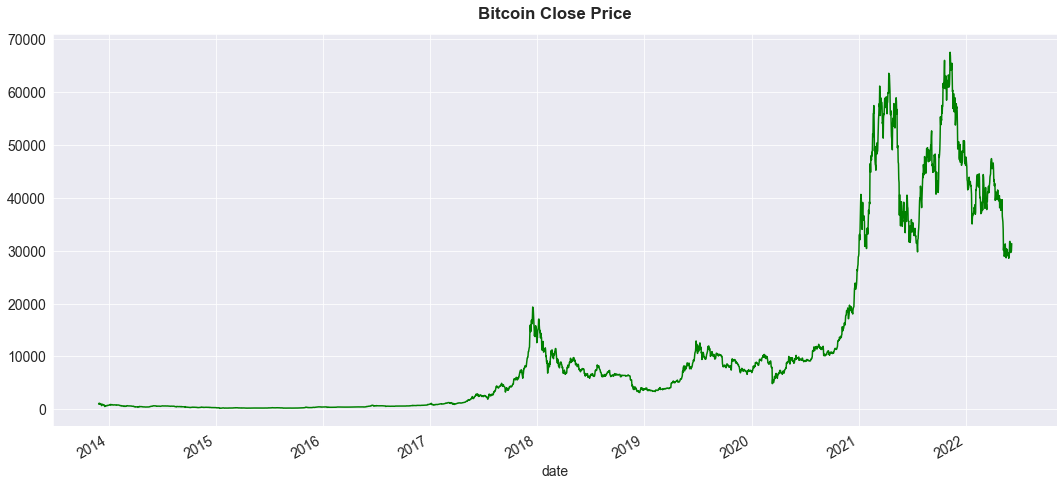

In [526]:
btc_df_viz['close'].plot(color="green") 
plt.title("Bitcoin Close Price", fontweight="bold", y=1.025)#fontname="Times New Roman"
plt.show()

<b> Volume Trend </b>

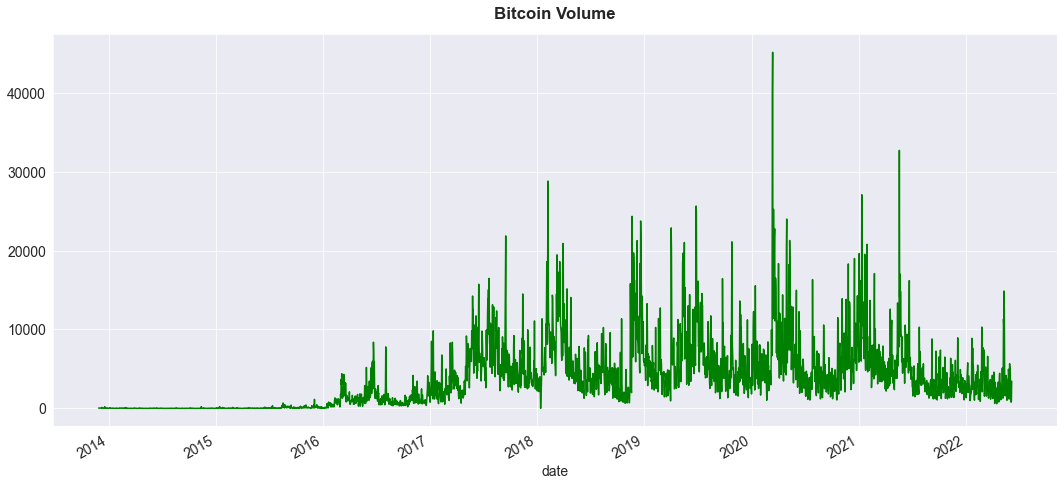

In [527]:
btc_df_viz['volume'].plot(color="green")
plt.title("Bitcoin Volume", fontweight="bold", y=1.025)
plt.show()

<b> Trades Trend </b>

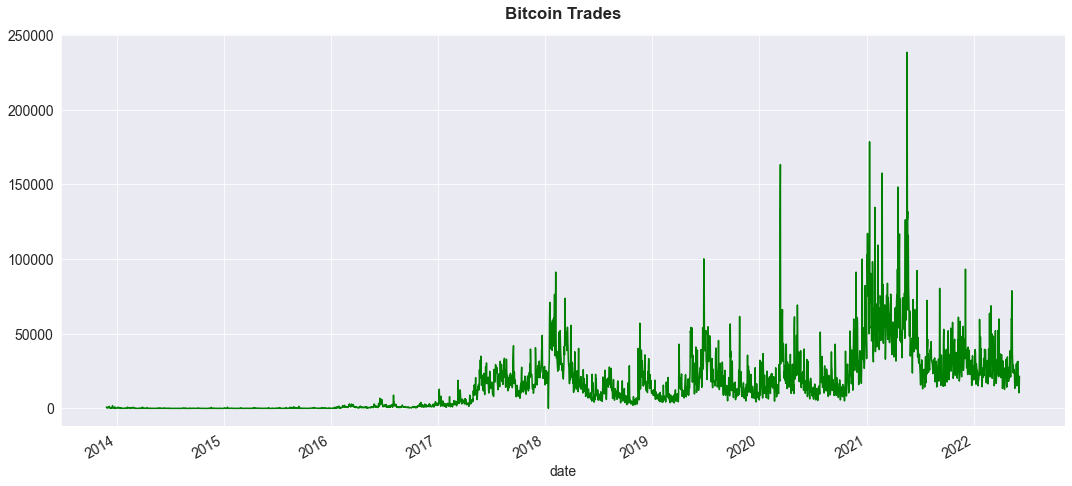

In [528]:
btc_df_viz['trades'].plot(color="green")
plt.title("Bitcoin Trades", fontweight="bold", y=1.025)
plt.show()

<b> Box Plot Close Price </b>

Text(0, 0.5, '')

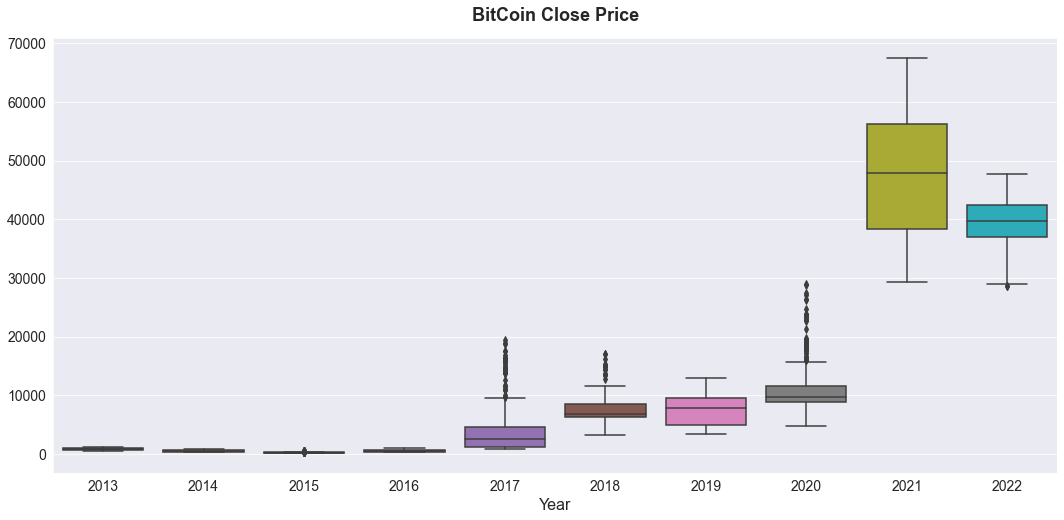

In [529]:
box = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["close"], data=btc_df_viz)

box.set_title("BitCoin Close Price",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box.set_xlabel("Year", fontsize=16)
box.set_ylabel(None, fontsize=16)


<b> Box Plot Volume </b>

Text(0, 0.5, '')

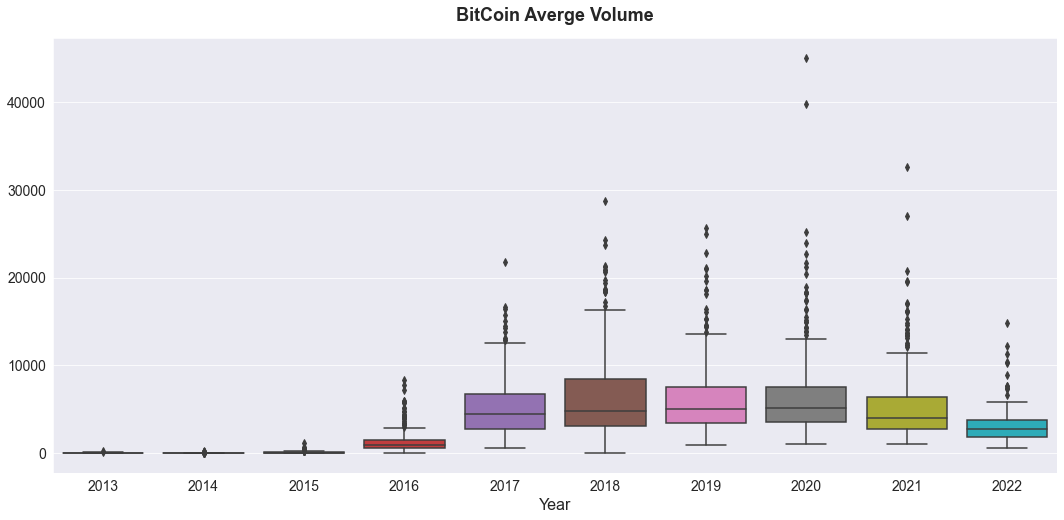

In [530]:
box1 = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["volume"], data=btc_df_viz)

box1.set_title("BitCoin Averge Volume",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box1.set_xlabel("Year", fontsize=16)
box1.set_ylabel(None, fontsize=16)


<b> Box Plot Trades </b>

Text(0, 0.5, '')

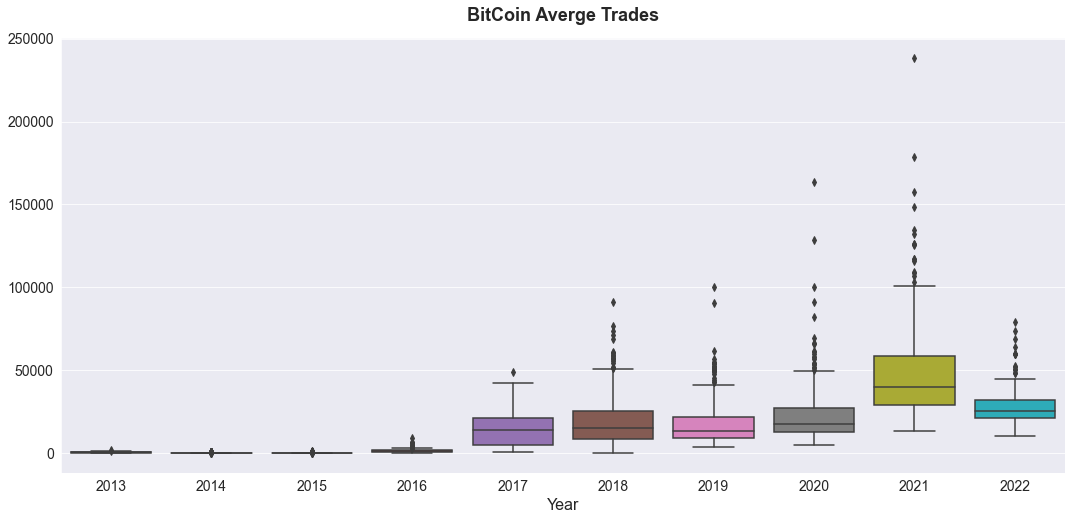

In [531]:
box2 = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["trades"], data=btc_df_viz)

box2.set_title("BitCoin Averge Trades",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box2.set_xlabel("Year", fontsize=16)
box2.set_ylabel(None, fontsize=16)

#### 2022 Monthly Close Price 

In [532]:
btc_df_viz_2022 = btc_df_viz[:]

In [533]:
filt = btc_df_viz_2022["year"]='2022'

In [534]:
btc_df_viz_2022 = btc_df_viz_2022[filt]

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_30974/3275679836.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  btc_df_viz_2022 = btc_df_viz_2022[filt]


Text(0, 0.5, '')

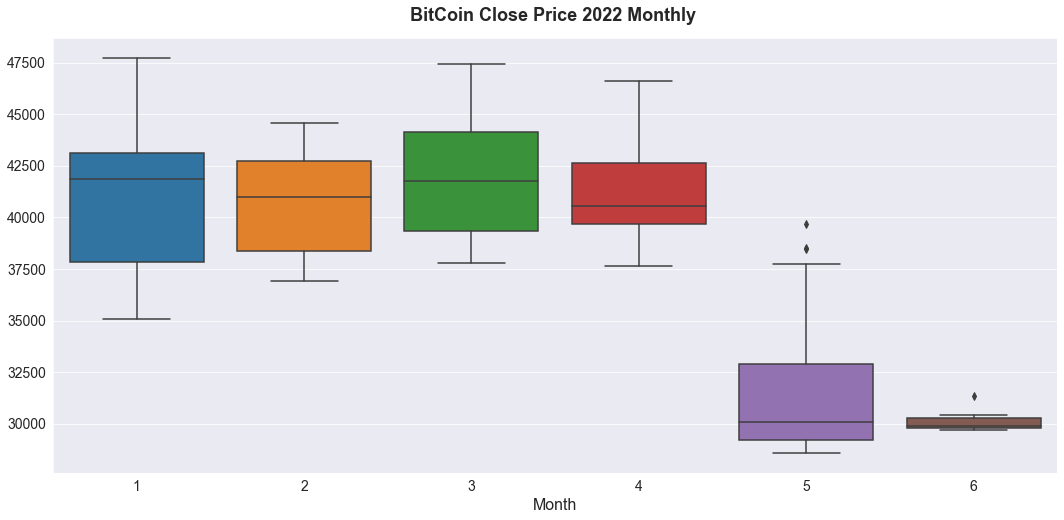

In [535]:
box = sns.boxplot(x=btc_df_viz_2022["month"], y=btc_df_viz_2022["close"], data=btc_df_viz_2022)

box.set_title("BitCoin Close Price 2022 Monthly ",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box.set_xlabel("Month", fontsize=16)
box.set_ylabel(None, fontsize=16)

In [536]:
btc_df_viz = btc_df_viz.astype({"year":"int"})

In [537]:
btc_avg = btc_df_viz[:]
btc_avg

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814
2013-11-30,2013,11,30,1155.62219,1189.10145,1094.38283,1114.24001,22.761523,365,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562.0,0.017532,0.101419,0.082680,0.165042,0.054402,0.268623,877.595607,975.675600,837.885186,927.895049,27.908455,393.428571,0.077430,0.064616,0.072709,0.061428,0.299319,0.216921,884.654620,650.853472,375.012714
2013-12-01,2013,12,1,1112.01598,1130.00000,770.00000,953.72943,52.505576,905,1155.62219,1189.10145,1094.38283,1114.24001,22.761523,365.0,0.141476,-0.008091,0.080986,-0.043920,-0.346446,-0.350534,928.920399,1016.393450,884.402399,968.392544,25.006714,412.571429,0.062716,0.061247,0.069921,0.058034,0.414079,0.270971,934.007908,690.715473,394.820714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-02,2022,6,2,29790.00000,31449.20000,29572.80000,30427.00000,2470.229023,19405,31781.00000,31929.00000,29328.60000,29790.00000,5171.217781,31383.0,0.002226,-0.014537,-0.059489,-0.062645,0.489934,0.017904,29889.614286,30648.557143,28981.314286,29931.414286,3734.049740,26170.000000,0.012919,0.012442,0.012874,0.010477,0.429364,0.159159,29852.444444,29816.405000,34602.480000
2022-06-03,2022,6,3,30431.30000,30658.90000,29255.00000,29676.40000,2472.705420,18044,29790.00000,31449.20000,29572.80000,30427.00000,2470.229023,19405.0,-0.062647,-0.015027,0.008326,0.021383,-0.522312,-0.381672,29928.271429,30876.442857,29276.714286,30108.571429,3377.918417,24755.571429,0.010495,0.008596,0.001014,0.002066,0.498077,0.160941,29940.800000,29876.625000,34388.020000
2022-06-04,2022,6,4,29676.40000,29954.50000,29450.10000,29850.00000,783.344337,10432,30431.30000,30658.90000,29255.00000,29676.40000,2472.705420,18044.0,0.021527,-0.025129,-0.010746,-0.024669,0.001002,-0.070137,30109.042857,31058.214286,29420.285714,30265.200000,3100.954225,23052.571429,0.002069,0.008034,0.010997,0.006734,0.315893,0.029863,29958.144444,29858.035000,34182.450000


In [538]:
btc_avg = pd.DataFrame(btc_df_viz.groupby(['year'])['open'].mean())
btc_avg["high"] = pd.DataFrame(btc_df_viz.groupby(['year'])['high'].mean())
btc_avg["low"] = pd.DataFrame(btc_df_viz.groupby(['year'])['low'].mean())
btc_avg["close"] = pd.DataFrame(btc_df_viz.groupby(['year'])['close'].mean())
btc_avg["volume"] = pd.DataFrame(btc_df_viz.groupby(['year'])['volume'].mean())
btc_avg["trades"] = pd.DataFrame(btc_df_viz.groupby(['year'])['trades'].mean())
btc_avg

,open,high,low,close,volume,trades
year,,,,,,
2013,834.430256,887.545685,763.786884,828.310699,43.388851,489.028571
2014,533.016193,548.639927,515.940908,531.499985,14.195329,102.535211
2015,271.471425,278.831813,265.153542,272.323858,77.278983,122.101370
2016,566.870884,576.048015,557.450315,568.276695,1283.666737,1306.759563
2017,3936.776534,4118.183701,3767.023499,3972.502397,5048.121496,14161.161644
2018,7552.732329,7783.027671,7258.388493,7523.407671,6301.052699,19339.312329
2019,7355.562466,7562.660548,7131.104658,7364.964110,6106.849901,17539.893151
2020,11056.251366,11336.646721,10783.763934,11116.068579,6386.292323,22526.715847
2021,47378.112329,48812.425753,45668.609041,47426.086301,5254.154224,47278.846575


<b>Yearly Average Close Price </b>

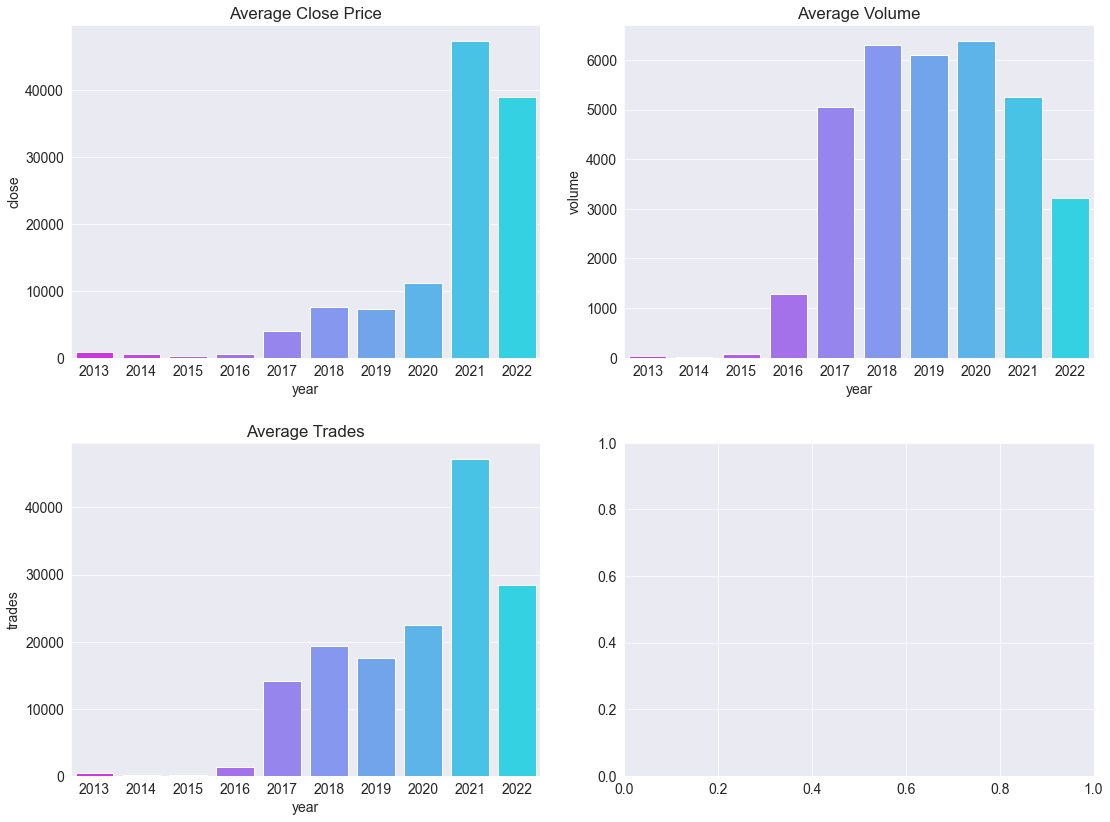

In [539]:
fig, axes = plt.subplots(2,2, figsize=(16,12))

axes[0,0].set_title("Average Close Price")
sns.barplot(ax=axes[0,0], data = btc_avg, x = btc_avg.index, y=btc_avg["close"], palette="cool_r")

axes[0,1].set_title("Average Volume")
sns.barplot(ax=axes[0,1], data = btc_avg, x = btc_avg.index, y=btc_avg["volume"],palette="cool_r")


axes[1,0].set_title("Average Trades",)
sns.barplot(ax=axes[1,0], data = btc_avg, x = btc_avg.index, y=btc_avg["trades"],palette="cool_r")


plt.tight_layout(pad=2)

In [540]:
#df_2013 = btc_df_viz[btc_df_viz["year"]==2013]
#df_2014 = btc_df_viz[btc_df_viz["year"]==2014]
#df_2015 = btc_df_viz[btc_df_viz["year"]==2015]
#df_2016 = btc_df_viz[btc_df_viz["year"]==2016]
#df_2017 = btc_df_viz[btc_df_viz["year"]==2017]
#df_2018 = btc_df_viz[btc_df_viz["year"]==2018]
#df_2019 = btc_df_viz[btc_df_viz["year"]==2019]
#df_2020 = btc_df_viz[btc_df_viz["year"]==2020]
#df_2021 = btc_df_viz[btc_df_viz["year"]==2021]
#df_2022 = btc_df_viz[btc_df_viz["year"]==2022]

#### Heatmap showing  correlation score

In [541]:
cor_df= btc_df_viz.corr()

<AxesSubplot:>

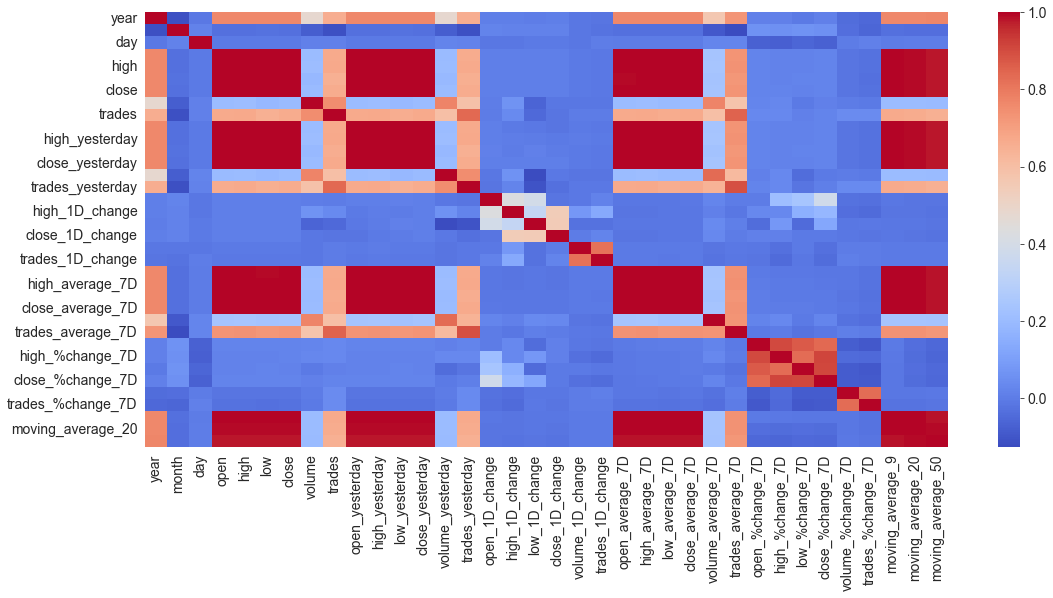

In [542]:
sns.heatmap(cor_df, cmap="coolwarm")

#### DataFrame with Dropping some Features

In [543]:
btc_df_less_features = btc_df.drop(["year", "month", "day"], axis=1) # not important

In [544]:
btc_df_less_features = btc_df_less_features.drop(["open", "high", "low","trades", "volume"], axis=1) 

# in reality, we don't know this on the current day or tomorrow day we want to predict
# we only know yesterday'open, yesterday'high, yesterday's low, and yesterday's close

In [545]:
btc_df_less_features.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,1165.42500,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


<b> Save dataframe for machine learning model </b>

In [546]:
btc_df_less_features.to_csv("data/btc_df_less_features.csv")

## MACHINE LEARNING MODEL

* Split train-test data using date since it's a time series data

* not using train-test-split from sklearn since it will mix up the data

In [547]:
btc_ml_all = pd.read_csv("data/btc_df_less_features.csv", index_col=0)

In [548]:
btc_ml_all.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,1165.42500,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [549]:
btc_ml_all.tail(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-05,29907.6,29676.4,29954.5,29450.1,29850.0,783.344337,10432.0,-0.024807,-0.022975,0.006669,0.005850,-0.683204,-0.421858,30265.671429,31161.857143,29556.000000,30383.771429,3044.968723,22382.000000,0.006855,0.006682,0.005592,0.006180,0.331916,0.016631,30031.822222,29785.690,33968.052
2022-06-06,31356.3,29850.8,30162.4,29514.0,29907.6,963.561140,11190.0,0.005877,0.006941,0.002170,0.001930,0.230061,0.072661,30384.342857,31248.628571,29655.142857,30449.085714,2997.989385,21800.428571,0.006181,0.004165,0.005280,0.004817,0.339114,0.027110,30179.333333,29789.765,33758.584
2022-06-07,29300.0,29907.6,31725.6,29881.9,31356.3,3447.462926,21505.0,0.001903,0.051826,0.012465,0.048439,2.577835,0.921805,30449.642857,31182.800000,29740.871429,30398.314286,2682.755914,20398.571429,0.004820,0.003563,0.003986,0.002974,0.357737,0.036215,30438.922222,29837.165,33592.086


#### Drop the last row because we want to predict the price of the current day

In [550]:
last_row = btc_ml_all[-1:]
last_row

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-07,29300.0,29907.6,31725.6,29881.9,31356.3,3447.462926,21505.0,0.001903,0.051826,0.012465,0.048439,2.577835,0.921805,30449.642857,31182.8,29740.871429,30398.314286,2682.755914,20398.571429,0.00482,0.003563,0.003986,0.002974,0.357737,0.036215,30438.922222,29837.165,33592.086


In [551]:
btc_ml = btc_ml_all[:-1]
btc_ml.head(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [552]:
btc_ml.tail(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-05,29907.6,29676.4,29954.5,29450.1,29850.0,783.344337,10432.0,-0.024807,-0.022975,0.006669,0.00585,-0.683204,-0.421858,30265.671429,31161.857143,29556.000000,30383.771429,3044.968723,22382.000000,0.006855,0.006682,0.005592,0.006180,0.331916,0.016631,30031.822222,29785.690,33968.052
2022-06-06,31356.3,29850.8,30162.4,29514.0,29907.6,963.561140,11190.0,0.005877,0.006941,0.002170,0.00193,0.230061,0.072661,30384.342857,31248.628571,29655.142857,30449.085714,2997.989385,21800.428571,0.006181,0.004165,0.005280,0.004817,0.339114,0.027110,30179.333333,29789.765,33758.584


#### Split train-test 85:15
* Can't use train-test split because it will shuffle the data/date index

In [553]:
len(btc_ml)

3104

In [554]:
train_size = (85*(len(btc_ml)))//100
train_size

2638

**Train Set**

In [555]:
train_set = btc_ml.iloc[0:train_size]
train_set.tail(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-23,48899.8,57475.9,57567.6,45002.0,54154.8,12299.535705,125363.0,0.027612,-0.013223,-0.189014,-0.057822,2.299377,1.732649,52882.442857,55098.728571,50292.785714,53778.328571,6791.996297,70336.000000,0.025110,0.023508,0.024293,0.024665,0.103820,0.030814,52559.455556,47226.140,39926.062
2021-02-24,49727.7,54128.0,54200.0,45000.0,48899.8,17080.212490,157669.0,-0.058249,-0.058498,-0.000044,-0.097037,0.388688,0.257700,53766.857143,55613.028571,50001.342857,53732.771429,8349.809410,83729.714286,0.024649,0.023507,0.001325,0.018498,0.360539,0.248032,52587.244444,47787.585,40263.098
2021-02-25,47061.5,48899.6,51442.5,47015.7,49727.7,8110.232977,75094.0,-0.096593,-0.050876,0.044793,0.016931,-0.525168,-0.523724,53726.000000,55422.014286,49722.528571,53389.585714,8462.580260,84806.714286,0.018437,0.010616,-0.002837,0.000816,0.393652,0.278820,52786.200000,48425.020,40576.652


**Test Set**

In [556]:
test_set = btc_ml[train_size:]
test_set.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-26,46314.5,49726.1,52071.9,46702.0,47061.5,7523.627857,69227.0,0.016902,0.012235,-0.006672,-0.053616,-0.072329,-0.078129,53382.585714,55352.985714,49122.214286,52741.1,8949.069152,88166.142857,0.000917,-0.002806,-0.002291,-0.005215,0.292134,0.195862,52546.511111,48863.260,40780.348
2021-02-27,46170.2,47072.1,48449.0,44120.3,46314.5,10050.938088,82935.0,-0.053372,-0.069575,-0.055280,-0.015873,0.335916,0.198015,52737.100000,54224.285714,48184.628571,51367.9,9234.089952,89244.000000,-0.005220,-0.000451,-0.008895,-0.011425,0.344296,0.230894,51900.344444,49216.135,40916.858
2021-02-28,45245.4,46307.2,48350.0,45022.9,46170.2,4235.548964,43663.0,-0.016250,-0.002043,0.020458,-0.003116,-0.578592,-0.473527,51362.914286,52917.142857,46907.628571,49972.4,9003.990259,85689.571429,-0.011366,-0.020705,-0.016172,-0.025669,0.255693,0.166428,51296.933333,49580.900,41026.928


**X_train, y_train, X_test, y_test**

<b>X_train</b>

In [557]:
X_train_new = train_set.drop(["close"], axis=1)
X_train_new.head(3)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [558]:
X_train = X_train_new.values
X_train.shape

(2638, 27)

<b>X_test</b>

In [559]:
X_test_new = test_set.drop(["close"], axis=1)

In [560]:
X_test_new.head(3)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-26,49726.1,52071.9,46702.0,47061.5,7523.627857,69227.0,0.016902,0.012235,-0.006672,-0.053616,-0.072329,-0.078129,53382.585714,55352.985714,49122.214286,52741.1,8949.069152,88166.142857,0.000917,-0.002806,-0.002291,-0.005215,0.292134,0.195862,52546.511111,48863.260,40780.348
2021-02-27,47072.1,48449.0,44120.3,46314.5,10050.938088,82935.0,-0.053372,-0.069575,-0.055280,-0.015873,0.335916,0.198015,52737.100000,54224.285714,48184.628571,51367.9,9234.089952,89244.000000,-0.005220,-0.000451,-0.008895,-0.011425,0.344296,0.230894,51900.344444,49216.135,40916.858
2021-02-28,46307.2,48350.0,45022.9,46170.2,4235.548964,43663.0,-0.016250,-0.002043,0.020458,-0.003116,-0.578592,-0.473527,51362.914286,52917.142857,46907.628571,49972.4,9003.990259,85689.571429,-0.011366,-0.020705,-0.016172,-0.025669,0.255693,0.166428,51296.933333,49580.900,41026.928


In [561]:
X_test = X_test_new.values
X_test.shape

(466, 27)

<b> y_train </b>

In [562]:
y_train_new = train_set["close"]

In [563]:
y_train = y_train_new.values
y_train.shape

(2638,)

<b>y_test</b>

In [564]:
y_test_new = test_set["close"]
y_test = y_test_new.values
y_test.shape

(466,)

## Support Vector Machine

In [565]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import mean_squared_error, r2_score
from sklearn.svm import SVR

### Scale featues

In [566]:
scaler = StandardScaler()

In [567]:
X_scaled_train = scaler.fit_transform(X_train)

In [568]:
X_scaled_test = scaler.transform(X_test) 
# not using fit to avoid data leakage 

### Base Model1:  Not Scale and Not Adjust Parameters

In [569]:
svr_base1 = SVR()

In [570]:
svr_base1.fit(X_train , y_train)

SVR()

In [571]:
pred_base1 = svr_base1.predict(X_test)

In [572]:
print(np.sqrt(mean_squared_error(y_test, pred_base1)))

43830.6902366062


In [573]:
print(r2_score(y_test, pred_base1))

-20.31869079526877


### Base Model2: Scale but Not Adjust Parameters

In [574]:
svr_base2 = SVR()

In [575]:
svr_base2.fit(X_scaled_train, y_train)

SVR()

In [576]:
pred_base2 = svr_base2.predict(X_scaled_test)

In [577]:
print(np.sqrt(mean_squared_error(y_test, pred_base2)))

43747.91815025822


In [578]:
print(r2_score(y_test, pred_base2))

-20.238248240836825


### Model 3: Adjusted Model: Scale + Adjust Parameters

In [579]:
param_grid = {'kernel': ['linear'], 'C': [100,300, 500], 'epsilon': [0.00001, 0.0001, 0.001]}

In [580]:
svr = SVR()

In [581]:
%%time
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2')

CPU times: user 150 µs, sys: 662 µs, total: 812 µs
Wall time: 6.4 ms


In [582]:
%%time
grid_search.fit(X_scaled_train, y_train)

CPU times: user 1min 23s, sys: 1.87 s, total: 1min 25s
Wall time: 1min 38s


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [100, 300, 500],
                         'epsilon': [1e-05, 0.0001, 0.001],
                         'kernel': ['linear']},
             scoring='r2')

In [583]:
%%time
print(grid_search.best_params_)

{'C': 500, 'epsilon': 0.0001, 'kernel': 'linear'}
CPU times: user 115 µs, sys: 50 µs, total: 165 µs
Wall time: 118 µs


In [584]:
svr_best = grid_search.best_estimator_

In [585]:
pred_svr_adjusted = svr_best.predict(X_scaled_test)

In [586]:
print(np.sqrt(mean_squared_error(y_test, pred_svr_adjusted)))

1756.9766054033748


In [587]:
print(r2_score(y_test, pred_svr_adjusted))

0.9657440616411173


In [588]:
len(y_test)

466

In [589]:
len(pred_svr_adjusted)

466

In [590]:
test_set["close"]

date
2021-02-26    46314.5
2021-02-27    46170.2
2021-02-28    45245.4
2021-03-01    49620.7
2021-03-02    48486.2
               ...   
2022-06-02    30427.0
2022-06-03    29676.4
2022-06-04    29850.0
2022-06-05    29907.6
2022-06-06    31356.3
Name: close, Length: 466, dtype: float64

In [591]:
df_compare = pd.DataFrame(columns=["actual_price", "predicted_price"])

In [592]:
df_compare

,actual_price,predicted_price


In [593]:
df_compare["actual_price"] = test_set["close"]

In [594]:
df_compare["predicted_price"] = pred_svr_adjusted

In [595]:
df_compare["difference"] =  df_compare["actual_price"] - df_compare["predicted_price"] 

In [596]:
df_compare.head(10)

,actual_price,predicted_price,difference
date,,,
2021-02-26,46314.5,48494.133542,-2179.633542
2021-02-27,46170.2,46609.204322,-439.004322
2021-02-28,45245.4,46631.299960,-1385.899960
2021-03-01,49620.7,45185.440689,4435.259311
2021-03-02,48486.2,48756.257845,-270.057845
2021-03-03,50400.0,48530.995638,1869.004362
2021-03-04,48330.0,50425.061767,-2095.061767
2021-03-05,48734.7,48919.660013,-184.960013
2021-03-06,48899.9,48367.983617,531.916383


In [597]:
df_compare.tail(15)

,actual_price,predicted_price,difference
date,,,
2022-05-23,29070.0,29944.763706,-874.763706
2022-05-24,29631.8,29229.489435,402.310565
2022-05-25,29520.3,29342.068658,178.231342
2022-05-26,29186.9,29533.961074,-347.061074
2022-05-27,28580.0,28857.406002,-277.406002
2022-05-28,29020.0,28619.315680,400.684320
2022-05-29,29450.4,28900.354086,550.045914
2022-05-30,31711.7,29270.064354,2441.635646
2022-05-31,31780.9,31248.331687,532.568313


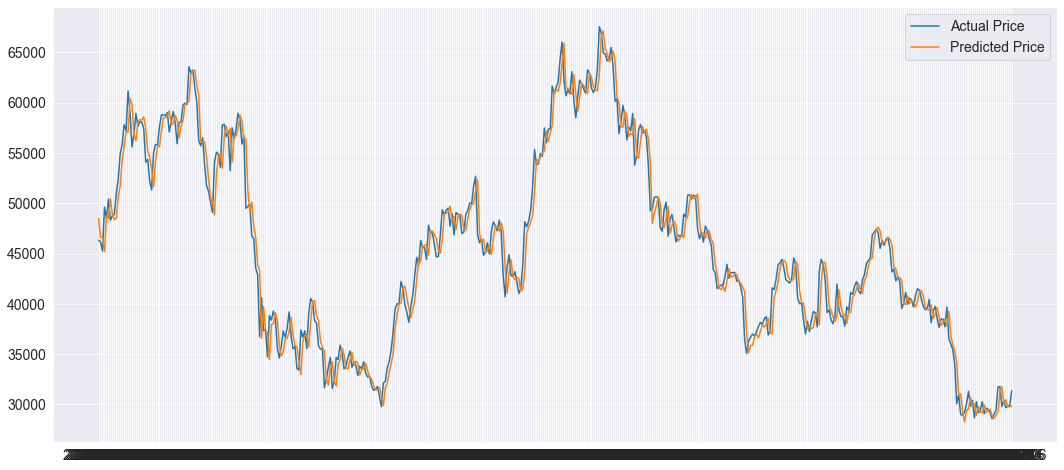

In [598]:
plt.plot(df_compare.index , df_compare.actual_price, label="Actual Price")
plt.plot(df_compare.index , df_compare.predicted_price, label="Predicted Price")
plt.legend()
plt.show()


# LIVE PREDICTION

* This section is trying to test the model performance on live prediction
* The model will predict the price the next day
* Therefore, there will be only one row of test set 
* y_test will be known at the end of trading day

#### 1. Dataset is from 2013 to Current day

In [599]:
btc_ml.head(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [600]:
btc_ml.tail(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-05,29907.6,29676.4,29954.5,29450.1,29850.0,783.344337,10432.0,-0.024807,-0.022975,0.006669,0.00585,-0.683204,-0.421858,30265.671429,31161.857143,29556.000000,30383.771429,3044.968723,22382.000000,0.006855,0.006682,0.005592,0.006180,0.331916,0.016631,30031.822222,29785.690,33968.052
2022-06-06,31356.3,29850.8,30162.4,29514.0,29907.6,963.561140,11190.0,0.005877,0.006941,0.002170,0.00193,0.230061,0.072661,30384.342857,31248.628571,29655.142857,30449.085714,2997.989385,21800.428571,0.006181,0.004165,0.005280,0.004817,0.339114,0.027110,30179.333333,29789.765,33758.584


#### 2. Training Set is from 2013 to yesterday price

<b> X_train</b>

In [601]:
X_train_new2 = btc_ml.drop(["close"], axis=1)
X_train_new2.head(2)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [602]:
X_train_new2.tail(2)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-05,29676.4,29954.5,29450.1,29850.0,783.344337,10432.0,-0.024807,-0.022975,0.006669,0.00585,-0.683204,-0.421858,30265.671429,31161.857143,29556.000000,30383.771429,3044.968723,22382.000000,0.006855,0.006682,0.005592,0.006180,0.331916,0.016631,30031.822222,29785.690,33968.052
2022-06-06,29850.8,30162.4,29514.0,29907.6,963.561140,11190.0,0.005877,0.006941,0.002170,0.00193,0.230061,0.072661,30384.342857,31248.628571,29655.142857,30449.085714,2997.989385,21800.428571,0.006181,0.004165,0.005280,0.004817,0.339114,0.027110,30179.333333,29789.765,33758.584


In [603]:
X_train2 = X_train_new2.values
X_train2.shape

(3104, 27)

<b> y_train </b>

In [604]:
y_train_new = btc_ml["close"]
y_train2 = y_train_new.values
y_train2.shape

(3104,)

#### 3. Test set is current trading day , today ( the last row)

In [605]:
X_test2 = last_row.drop(["close"], axis=1)
X_test2

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-07,29907.6,31725.6,29881.9,31356.3,3447.462926,21505.0,0.001903,0.051826,0.012465,0.048439,2.577835,0.921805,30449.642857,31182.8,29740.871429,30398.314286,2682.755914,20398.571429,0.00482,0.003563,0.003986,0.002974,0.357737,0.036215,30438.922222,29837.165,33592.086


<b> y_actual </b>

#### 4. Model Prediciton

In [606]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import mean_squared_error, r2_score
from sklearn.svm import SVR

### Scale featues

In [607]:
scaler = StandardScaler()

In [608]:
X_scaled_train2 = scaler.fit_transform(X_train2)

In [609]:
X_scaled_test2 = scaler.transform(X_test2) # not using fit to avoid data leakage 

/Users/daranee/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [610]:
param_grid2 = {'kernel': ['linear'], 'C': [100,300, 500], 'epsilon': [0.00001, 0.0001, 0.001]}

In [611]:
svr2 = SVR()

In [612]:
%%time
grid_search2 = GridSearchCV(svr2, param_grid2, cv=5, scoring='r2')

CPU times: user 84 µs, sys: 949 µs, total: 1.03 ms
Wall time: 1.84 ms


In [613]:
%%time
grid_search2.fit(X_scaled_train2, y_train2)

CPU times: user 1min 23s, sys: 983 ms, total: 1min 24s
Wall time: 1min 29s


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [100, 300, 500],
                         'epsilon': [1e-05, 0.0001, 0.001],
                         'kernel': ['linear']},
             scoring='r2')

In [614]:
%%time
print(grid_search2.best_params_)

{'C': 500, 'epsilon': 1e-05, 'kernel': 'linear'}
CPU times: user 128 µs, sys: 173 µs, total: 301 µs
Wall time: 376 µs


In [615]:
svr_best2 = grid_search2.best_estimator_

In [616]:
pred_svr_adjusted2 = svr_best2.predict(X_scaled_test2)

In [617]:
pred_svr_adjusted2

array([31090.54931143])

#### Create a new dataframe 

In [618]:
new_cols = ["date","predict", "actual"]

In [619]:
df_actual = pd.DataFrame(columns=new_cols)
df_actual

,date,predict,actual


In [620]:
df_actual["date"] = last_row.index
df_actual

,date,predict,actual
0,2022-06-07,NaN,NaN


In [621]:
df_actual["predict"] = pred_svr_adjusted2
df_actual

,date,predict,actual
0,2022-06-07,31090.549311,NaN


## Run Every Day

### Run at the End Of Day ( 5 p.m. Pacific Time)

In [622]:
daily_predict = pd.read_csv("data/daily_predict.csv", index_col=0)
daily_predict

,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,-197.475694
8,2022-06-03,30475.550098,29676.4,799.150098
9,2022-06-04,29829.815486,29850.0,-20.184514


### Actual Result

In [623]:
actual_close = btc_ml["close"][-1]
actual_close

31356.3

In [624]:
#daily_predict.set_index("date")

In [625]:
daily_predict["actual"][-1:] =  actual_close
daily_predict

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_30974/2655483848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_predict["actual"][-1:] =  actual_close


,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,-197.475694
8,2022-06-03,30475.550098,29676.4,799.150098
9,2022-06-04,29829.815486,29850.0,-20.184514


In [626]:
daily_predict["difference"] = daily_predict["predict"] - daily_predict["actual"]
daily_predict

,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,-197.475694
8,2022-06-03,30475.550098,29676.4,799.150098
9,2022-06-04,29829.815486,29850.0,-20.184514


### Store Updated data everyday

In [627]:
daily_predict = daily_predict.append(df_actual, ignore_index=True)
daily_predict

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_30974/4107255893.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  daily_predict = daily_predict.append(df_actual, ignore_index=True)


,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,-197.475694
8,2022-06-03,30475.550098,29676.4,799.150098
9,2022-06-04,29829.815486,29850.0,-20.184514


In [471]:
daily_predict.to_csv("data/daily_predict.csv")